In [ ]:
!pip install ultralytics dill torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.9/756.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [ ]:
import os
import gc
import glob
import yaml
import shutil
import fnmatch
import torchvision
import random

from ultralytics import YOLO
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Некоторые константы

In [ ]:
IMAGE_SIZE = (2048, 1447)
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.75
FONT_THICKNESS = 2
BORDER_THICKNESS = 2

Функция для отображения формулы на картинке. `image` - исходное изображение, `bboxes` - лист с координатами формул, `scores` - лист с точностью предсказания каждой формулы

In [ ]:
def plot_image_with_bbox(image, bboxes, scores, color, ax, save_path):
    bboxes = bboxes.astype(int)
    image = image.copy()

    for i, bbox in enumerate(bboxes):
        label = f"Formula: {scores[i]:.3f}"
        label_y = bbox[1] - 10 if bbox[1] - 10 > 10 else bbox[1] + 10
        (label_w, label_h), label_b = cv2.getTextSize(label, FONT, FONT_SCALE, FONT_THICKNESS)

        # Bounding box
        cv2.rectangle(
            img=image,
            pt1=(bbox[0], bbox[1]),
            pt2=(bbox[2], bbox[3]),
            color=color, thickness=BORDER_THICKNESS
        )
        # Text background
        cv2.rectangle(
            img=image,
            pt1=(bbox[0] - BORDER_THICKNESS + 1, bbox[1]),
            pt2=(bbox[0] + label_w, label_y - label_h),
            color=color, thickness=-1
        )
        # Text
        cv2.putText(
            img=image, text=label,
            org=(bbox[0], label_y + BORDER_THICKNESS + 1),
            fontFace=FONT, fontScale=FONT_SCALE,
            color=(255, 255, 255), thickness=FONT_THICKNESS
        )
    if save_path:
      cv2.imwrite(save_path, image)
    ax.imshow(image)
    ax.axis("off")

Добавляем `Google Drive API` для чтения/записи

In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
WEIGHTS_PATH = "/content/drive/My Drive/diploma/last.pt"
LABELS_PATH = "/content/drive/My Drive/diploma/labels"
OUTPUT_PATH = "/content/drive/My Drive/diploma/output"
os.makedirs(LABELS_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)

Загружаем предобученную модель, используя готовые веса

In [ ]:

model = YOLO(WEIGHTS_PATH)

Запускаем модель на данных из диска. Сериализуем `predictions`. В итоговом `.txt` файле в каждой строке содержится информация о каждой найденной формуле: `score`, затем координаты левого верхнего и правого нижнего угла прямоугольника

In [ ]:
INPUT_PATH = "/content/drive/My Drive/diploma/input"
with torch.no_grad():
  predictions = model.predict(
      source = INPUT_PATH,
      conf = 0.1,
      iou = 0.75,
      stream = True
  )


test_images = []

for prediction in predictions:
  if len(prediction.boxes.xyxy):
    name = os.path.splitext(os.path.basename(prediction.path))[0]
    boxes = prediction.boxes.xyxy.cpu().numpy()
    scores = prediction.boxes.conf.cpu().numpy()

    indices = torchvision.ops.nms(prediction.boxes.xyxy, prediction.boxes.conf, iou_threshold=0.05)
    print(f'ALL INDICES: {len(boxes)}. NMS INDICES: {len(indices)}')
    selected_indices = indices.cpu().tolist()

    boxes = boxes[selected_indices]
    scores = scores[selected_indices]

    test_images.append(name)
    label_path = os.path.join(LABELS_PATH, name + '.txt')

    with open(label_path, 'w') as f:
      for score, box in zip(scores, boxes):
                text = f"{score:0.4f} {' '.join(box.astype(str))}"
                f.write(text)
                f.write("\n")




image 1/3 /content/drive/My Drive/diploma/input/0001125-page03.jpg: 1024x736 27 math formulas, 3580.6ms
ALL INDICES: 27. NMS INDICES: 25
image 2/3 /content/drive/My Drive/diploma/input/Math_mode_spacing_example_pages-to-jpg-0001.jpg: 1024x736 19 math formulas, 3169.5ms
ALL INDICES: 19. NMS INDICES: 17
image 3/3 /content/drive/My Drive/diploma/input/test.jpg: 1024x640 36 math formulas, 2408.8ms
ALL INDICES: 36. NMS INDICES: 25
Speed: 14.1ms preprocess, 3053.0ms inference, 8.7ms postprocess per image at shape (1, 3, 1024, 640)


In [ ]:
def find_file_in_dir(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if os.path.splitext(name)[0] == pattern:
              result.append(name)
    return result

Отображаем результат

/content/drive/My Drive/diploma/output/0001125-page03.jpg
/content/drive/My Drive/diploma/output/Math_mode_spacing_example_pages-to-jpg-0001.jpg


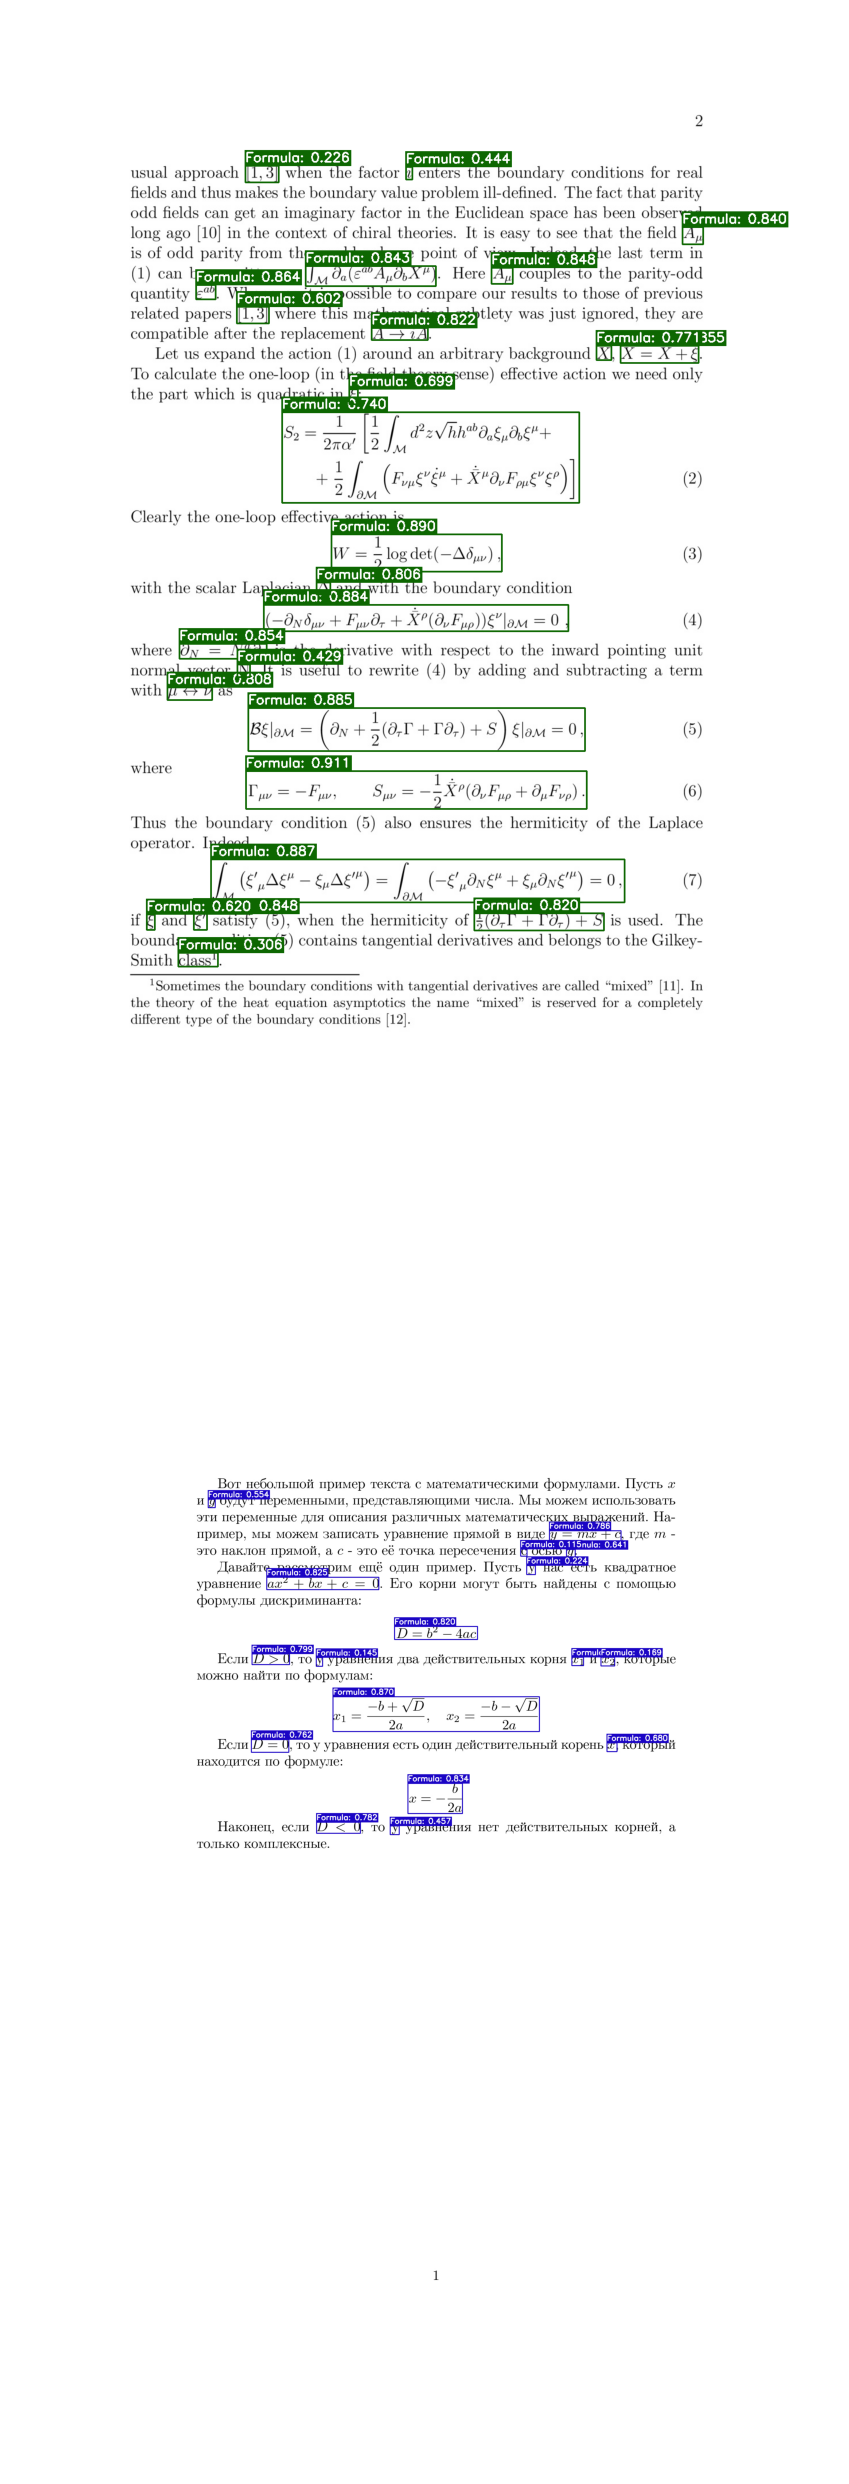

In [ ]:
files_number = len([name for name in os.listdir(INPUT_PATH) if os.path.isfile(os.path.join(INPUT_PATH, name))])
NUM_IMAGES = min(files_number, 2)

fig, axs = plt.subplots(NUM_IMAGES, 1, figsize=(32, 32), squeeze=False)
axs = axs.flatten()

plt.subplots_adjust(wspace=0.1, hspace=0.1)

image_names = random.sample(test_images, NUM_IMAGES)

for i, image_name in enumerate(image_names):
    label_name = image_name + '.txt'
    image_name = find_file_in_dir(image_name, INPUT_PATH)[-1]
    image_path = os.path.join(
        INPUT_PATH,
        image_name
    )

    output_path = os.path.join(OUTPUT_PATH, image_name)
    print(output_path)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    label_path = os.path.join(LABELS_PATH, label_name)
    label = pd.read_csv(label_path, sep=" ", header=None).values

    scores = label[:, 0]
    bboxes = label[:, 1:]
    color = np.random.randint(0, 255, (3,)).tolist()

    plot_image_with_bbox(image, bboxes, scores, color, axs[i], output_path)